In [4]:
from environment import TicTacToe
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.connectors.env_to_module import FlattenObservations
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from ray.rllib.algorithms.bc.torch.default_bc_torch_rl_module import DefaultBCTorchRLModule
from ray.rllib.core.rl_module.default_model_config import DefaultModelConfig
from rl_module import VPGTorchRLModule
import numpy as np
import torch
import matplotlib.pyplot as plt
from ray.rllib.core.rl_module.rl_module import RLModule

In [17]:
player1 = RLModule.from_checkpoint("C:/Users/kouas/Documents/RL_revisions/tic_tac_toe/weights/learner_group/learner/rl_module/p1")

In [18]:
player1

VPGTorchRLModule(
  (_policy_net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=9, bias=True)
  )
  (_value_function): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [2]:
env = TicTacToe(config={"render": "human"})

In [3]:
config = (
    PPOConfig()
    # FrozenLake has a discrete observation space (ints).
    .environment(TicTacToe,
                 env_config={"render": "human"})
    .env_runners(
        num_env_runners=3,
        num_envs_per_env_runner=2,
        batch_mode="complete_episodes",
    )
    .multi_agent(
        policies={"p1", "p2"},
        policy_mapping_fn=lambda agent_id, episode, **kw: f"p{agent_id[-1]}",
        

    )
    .rl_module(
        rl_module_spec=MultiRLModuleSpec(
            rl_module_specs={
                "p1": RLModuleSpec(
                    module_class=VPGTorchRLModule,
                    model_config={"hidden_dim_actor": 32,
                                  "hidden_dim_critic": 16,
                                  "agent_name": "player1"},
                    observation_space=env.observation_spaces["player1"],
                ),
                "p2": RLModuleSpec(
                    module_class=VPGTorchRLModule,
                    model_config={"hidden_dim_actor": 8,
                                  "hidden_dim_critic": 8,
                                  "agent_name": "player2"},
                    observation_space=env.observation_spaces["player2"]
                ),
            }
        )
    )
    .training(use_critic=True,
              use_gae=True,
              lr=0.03,
              train_batch_size_per_learner=20000,
              minibatch_size=3080,
              num_epochs=3
              )  # Enable critic and GAE
    .evaluation(evaluation_interval=1,
                evaluation_duration_unit="episodes",
                evaluation_duration=5)
)

In [4]:
ppo = config.build_algo()

2025-04-12 22:28:57,198	WARNING algorithm_config.py:4704 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-04-12 22:29:00,280	INFO worker.py:1852 -- Started a local Ray instance.
(MultiAgentEnvRunner pid=2988) 2025-04-12 22:29:05,260	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
2025-04-12 22:29:05,599	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space

In [5]:
# Initialize lists to store rewards for each agent
test_rewards_p1 = []
test_rewards_p2 = []
episodes = []

# Training loop
for i in range(40):  # Train for 100 iterations
    train_results = ppo.train()
    
    # Extract rewards for each agent
    test_rewards_p1.append(train_results["env_runners"]["agent_episode_returns_mean"]["player1"])
    test_rewards_p2.append(train_results["env_runners"]["agent_episode_returns_mean"]["player2"])
    print("--------------------------------")
    print(f"Iteration {i + 1}:")
    print("--------------------------------")
    episodes.append(i + 1)

the winner is:  player2
the winner is:  player1
the winner is:  player2
the winner is:  player2
--------------------------------
Iteration 1:
--------------------------------
the winner is:  player1
the winner is:  player1
the winner is:  player1
the winner is:  player1
the winner is:  player1
--------------------------------
Iteration 2:
--------------------------------
the winner is:  player1
the winner is:  player1
the winner is:  player1
the winner is:  player2
the winner is:  player2
--------------------------------
Iteration 3:
--------------------------------
the winner is:  player1
the winner is:  player2
the winner is:  player2
the winner is:  player1
the winner is:  player1
--------------------------------
Iteration 4:
--------------------------------
the winner is:  player1
the winner is:  player1
the winner is:  player2
the winner is:  player1
the winner is:  player2
the winner is:  player2
--------------------------------
Iteration 5:
--------------------------------
the w

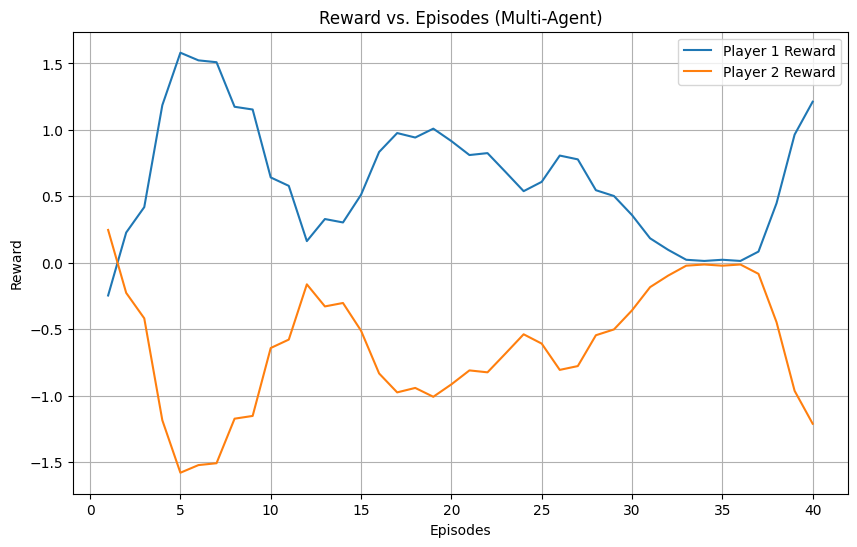

In [6]:
# Plot rewards for both agents
plt.figure(figsize=(10, 6))
plt.plot(episodes, test_rewards_p1, label="Player 1 Reward")
plt.plot(episodes, test_rewards_p2, label="Player 2 Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward vs. Episodes (Multi-Agent)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("mean reward player1: ", np.mean(test_rewards_p1))
print("mean reward player2: ", np.mean(test_rewards_p2))

In [7]:
ppo.save_to_path("c:/Users/kouas/Documents/RL_revisions/tic_tac_toe/weights/")

'c:\\Users\\kouas\\Documents\\RL_revisions\\tic_tac_toe\\weights'

In [ ]:
ppo = config.build_algo()

In [5]:
ppo.restore_from_path("c:/Users/kouas/Documents/RL_revisions/tic_tac_toe/weights/")

In [6]:
agent_1 = ppo.get_module("p1")
agent_2 = ppo.get_module("p2")

In [2]:
#Simulate a game
obs, _ = env.reset()
terminated = {"__all__": False}
env.render()
while not terminated["__all__"]:
    if obs.get(np.str_('player1'), 0):
        #player 1's turn
        player_1_obs = obs.get(np.str_('player1'), 0)
        #convert to tensor
        player_1_obs["observation"] = torch.from_numpy(player_1_obs["observation"]).float()
        player_1_obs["action_mask"] = torch.from_numpy(player_1_obs["action_mask"]).float()
        action_distribution = agent_1._forward_inference(
            {"obs": player_1_obs}
        )
        action = action_distribution["action_dist_inputs"].argmax().item()
        obs, reward, terminated, truncated, info = env.step({"player1": action})
    else:
        #player 2's turn
        player_2_obs = obs.get(np.str_('player2'), 0)
        #convert to tensor
        player_2_obs["observation"] = torch.from_numpy(player_2_obs["observation"]).float()
        player_2_obs["action_mask"] = torch.from_numpy(player_2_obs["action_mask"]).float()
        action_distribution = agent_2._forward_inference(
            {"obs": player_2_obs}
        )
        action = action_distribution["action_dist_inputs"].argmax().item()
        obs, reward, terminated, truncated, info = env.step({"player2": action})
    env.render()

NameError: name 'env' is not defined

In [1]:
list(range(0, 9))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
list(range(0, 9))[::3]

In [ ]:
terminated

In [ ]:
action_distribution["action_dist_inputs"].argmax().item()

In [ ]:
# Restore the trained PPO model
restored_ppo = config.build_algo()
restored_ppo.restore_from_path("c:/Users/kouas/Documents/RL_revisions/rock_paper_cisor/weights/")

In [ ]:
restored_ppo.evaluate()

In [ ]:
agent_1 = restored_ppo.get_module("p1")

In [ ]:
agent_1

In [ ]:
obs, _ = env.reset()

In [ ]:
obs

In [ ]:
to_send = {"obs": torch.tensor(list(obs.values())[0]).reshape(1, -1)}

In [ ]:
to_send

In [ ]:
agent_1.forward(to_send)